In [33]:
#import libraries

import pandas as pd
import warnings
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify
import datetime as dt

In [34]:
#import data

df=pd.read_csv("b.csv")

C:\Users\muralee\AppData\Local\Temp\ipykernel_8580\3452261143.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("b.csv")


Data Cleaning

In [35]:
len(df)

355994

In [36]:
df.head()

,customer_card_no,date,invoice_no,invoice_amount,invoice_profit
0,1000.0,2016-09-19,160919060.0,195.0,15.00
1,1000.0,2016-09-19,160919061.0,315.0,7.48
2,NaN,2016-09-19,160919062.0,370.0,67.55
3,NaN,2016-09-19,160919063.0,274.0,87.34
4,NaN,2016-09-19,160919064.0,560.0,107.00


In [37]:
#droping any missing values
df.dropna(inplace=True)
df.isna().sum()

customer_card_no    0
date                0
invoice_no          0
invoice_amount      0
invoice_profit      0
dtype: int64

In [38]:
len(df.customer_card_no.unique())

243

In [39]:
#checking data types
df.dtypes

customer_card_no     object
date                 object
invoice_no          float64
invoice_amount      float64
invoice_profit      float64
dtype: object

In [40]:
# convert object type into float and datetime
df['date'] = pd.to_datetime(df['date'])
df['customer_card_no'] = pd.to_numeric(df['customer_card_no'],errors='coerce')

In [41]:
df.dtypes

customer_card_no           float64
date                datetime64[ns]
invoice_no                 float64
invoice_amount             float64
invoice_profit             float64
dtype: object

Calculating RFM Metrics

Recency: How recently a customer has made a purchase?

In [42]:
df["date"].min()

Timestamp('2009-01-02 00:00:00')

In [43]:
df["date"].max()

Timestamp('2020-11-29 00:00:00')

In [44]:
today_date = dt.datetime(2020,11,29)

In [45]:
temp_df=(today_date-df.groupby("customer_card_no").agg({"date":"max"}))

In [46]:
temp_df.rename(columns={"date": "Recency"}, inplace = True)

In [47]:
temp_df.head()

,Recency
customer_card_no,
112.0,0 days
1000.0,0 days
1001.0,2 days
1002.0,3 days
1003.0,78 days


In [48]:
temp_df.shape

(164, 1)

In [49]:
recency_df = temp_df["Recency"].apply(lambda x: x.days)
recency_df.head()

customer_card_no
112.0      0
1000.0     0
1001.0     2
1002.0     3
1003.0    78
Name: Recency, dtype: int64

Frequency: How often a customer makes a purchase?

In [50]:
temp_df = df.groupby(["customer_card_no","invoice_no"]).agg({"invoice_no":"count"})

In [51]:
freq_df = temp_df.groupby("customer_card_no").agg({"invoice_no":"sum"})
freq_df.rename(columns={"invoice_no": "Frequency"}, inplace = True)
freq_df.head()

,Frequency
customer_card_no,
112.0,179
1000.0,301481
1001.0,601
1002.0,70
1003.0,175


Monetary Value: How much money a customer spends on purchases?

In [52]:
monetary_df = df.groupby("customer_card_no").agg({"invoice_amount":"sum"})
monetary_df.head()

,invoice_amount
customer_card_no,
112.0,2.511585e+05
1000.0,1.397696e+08
1001.0,1.029185e+06
1002.0,1.227425e+05
1003.0,6.178295e+05


In [53]:
monetary_df.rename(columns={"invoice_amount": "Monetary"}, inplace = True)

In [54]:
print(recency_df.shape,freq_df.shape,monetary_df.shape)

(164,) (164, 1) (164, 1)


In [55]:
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm.head()

,Recency,Frequency,Monetary
customer_card_no,,,
112.0,0,179,2.511585e+05
1000.0,0,301481,1.397696e+08
1001.0,2,601,1.029185e+06
1002.0,3,70,1.227425e+05
1003.0,78,175,6.178295e+05


In [56]:
# Recency , if the transaction happened recently give 5 points
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

#Frequency = , 5 =Most frequent , 1 = rarely
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'], 5, labels = [1, 2, 3, 4, 5])

#5 =best 1= least
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])


In [57]:
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
customer_card_no,,,,,,
112.0,0,179,2.511585e+05,5,4,4
1000.0,0,301481,1.397696e+08,5,5,5
1001.0,2,601,1.029185e+06,5,5,5
1002.0,3,70,1.227425e+05,4,3,3
1003.0,78,175,6.178295e+05,2,4,5


In [58]:
rfm["RFM_Score"] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
customer_card_no,,,,,,,
112.0,0,179,2.511585e+05,5,4,4,544
1000.0,0,301481,1.397696e+08,5,5,5,555
1001.0,2,601,1.029185e+06,5,5,5,555
1002.0,3,70,1.227425e+05,4,3,3,433
1003.0,78,175,6.178295e+05,2,4,5,245


Creating RFM Segments

In [59]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [60]:
rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Segment
customer_card_no,,,,,,,,
112.0,0,179,2.511585e+05,5,4,4,544,Champions
1000.0,0,301481,1.397696e+08,5,5,5,555,Champions
1001.0,2,601,1.029185e+06,5,5,5,555,Champions
1002.0,3,70,1.227425e+05,4,3,3,433,Potential Loyalists
1003.0,78,175,6.178295e+05,2,4,5,245,At Risk


In [61]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                    Recency Frequency   Monetary      
                       mean      mean       mean count
Segment                                               
About to Sleep         12.2      31.6    48020.1    16
At Risk               217.0     113.7   173364.5    24
Can't Loose           294.9    1324.7  1008285.4    10
Champions               1.1   11786.0  5748074.3    27
Hibernating           549.2      15.1    18791.9    32
Loyal Customers         8.3     388.8   317306.7    19
Need Attention         14.0     101.0   112308.6     2
New Customers           1.5       8.8    17617.0     4
Potential Loyalists     2.6      67.6   100113.9    26
Promising               5.2       6.2    31975.9     4


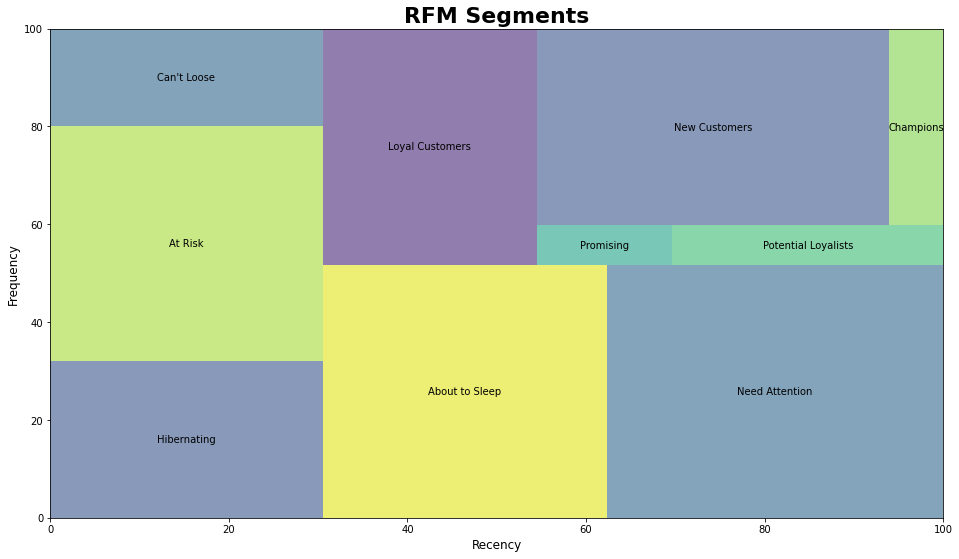

In [62]:
rfm_level_agg.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Hibernating',
                     'At Risk',
                     'Can\'t Loose',
                     'About to Sleep',
                     'Need Attention', 
                     'Loyal Customers',
                     'Promising',
                     'Potential Loyalists',
                     'New Customers',
                     'Champions',], alpha=.6 )
plt.title("RFM Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.axis('on')
plt.show()